# Assignment 1: NARMA10 task

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import mean_squared_error


Load the datset

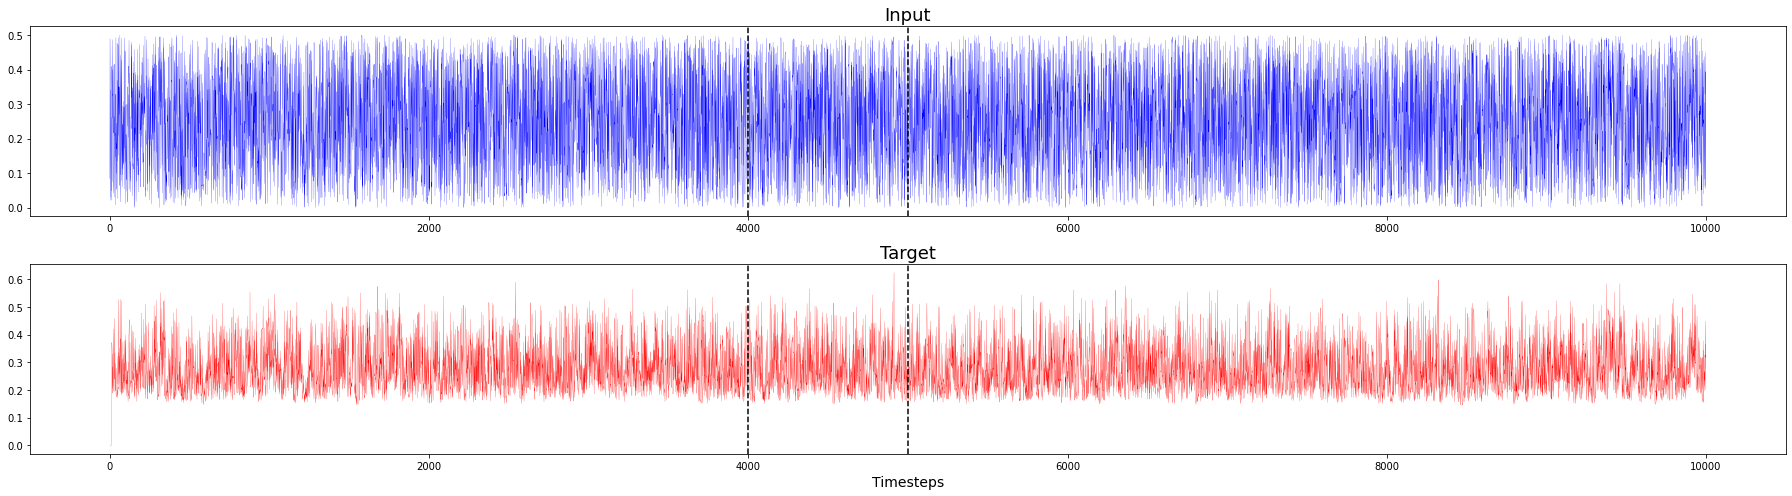

In [53]:
#load the data
x, y = np.loadtxt("NARMA10.csv", delimiter=",")


#split the dataset into training, validation and test
x_train = x[:4000]
#x_valid = x[4000:5000] #validation
x_test = x[4000:]

y_train = y[:4000]
#y_valid = y[4000:5000]
y_test = y[4000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.2)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.2)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

## Reservoir

In [54]:
#initialization
Nh = 100
Nx = 1
omega_x = 2 #??
omega_b = 0.2 #??
rho = 0.9


# Initialize weights Wx and Wh
Wx = 2 * np.random.rand(Nh, Nx) - 1
Wx = omega_x * Wx
Wh = 2 * np.random.rand(Nh, Nh) - 1
Wh = rho * (Wh / np.max(np.abs(np.linalg.eig(Wh)[0])))


# bias 
b = np.ones_like(Wx) 
b = omega_b * b


#Wx = sparse.random(Nh, 1, density=0.3, random_state=np.random.randint(0, 2))

'''
def reservoir (x, state, Wh, Wx, b):
    h = np.tanh(np.dot(Wh, state)+np.dot(Wx,x)+b)
    return h
'''

'\ndef reservoir (x, state, Wh, Wx, b):\n    h = np.tanh(np.dot(Wh, state)+np.dot(Wx,x)+b)\n    return h\n'

In [55]:

#Run the reservoir on the input stream


# Initialize state vector and hidden state history
state = np.zeros((Nh, 1))
H = state.copy()


for t in range(len(x_train)):
    state = np.tanh(Wh.dot(state) + Wx.dot(x_train[t]) + b)
    H = np.hstack((H, state))

print(b.shape)
print(Wx.shape)
print(H.shape)

#discard the washout
washout_size = 100 #va bene tenerlo costante
H = H[:, (washout_size+1):]
print(H.shape)

Y = y_train[washout_size:]
print(Y.shape)



(100, 1)
(100, 1)
(100, 4001)
(100, 3900)
(3900,)


train the readout

In [56]:
Wo = np.dot(Y, np.linalg.pinv(H))

Text(0.5, 1.0, 'MSE = 0.001514147714202514')

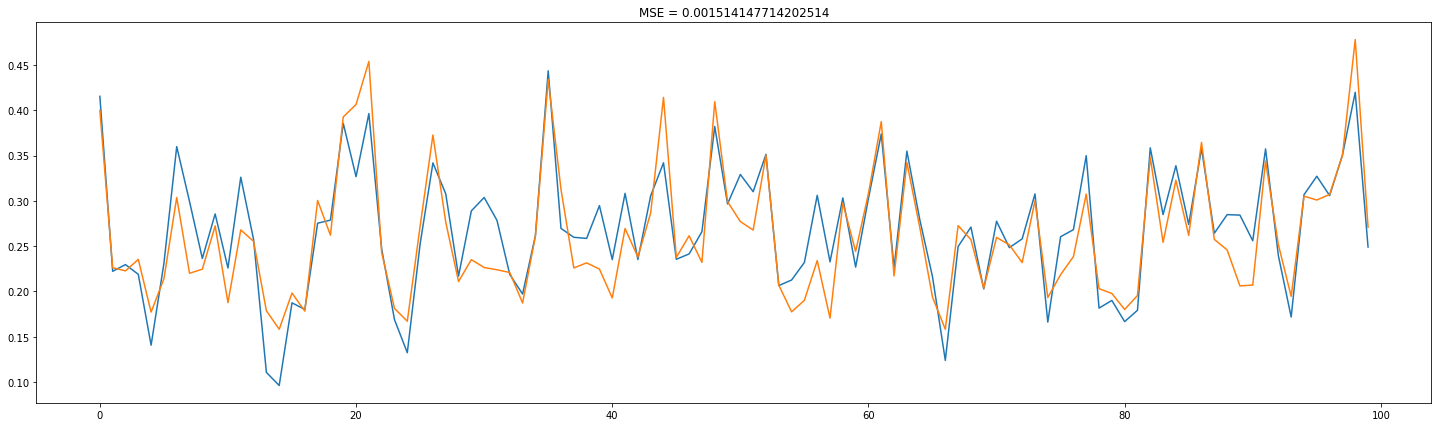

In [57]:
o_tr = np.dot(Wo, H)
err_tr = mean_squared_error(Y, o_tr)

plt.figure(figsize = (25,7))

plt.plot(o_tr[:100])
plt.plot(Y[:100])
plt.title(f'MSE = {err_tr}')


In [58]:
H = state

for t in range(len(x_test)):
    state = np.tanh(Wh.dot(state) + Wx.dot(x_test[t]) + b)
    H = np.hstack((H, state))

o_test = np.dot(Wo, H)
err_test = mean_squared_error(y_test, o_test[:-1])

plt.figure(figsize = (25,7))

plt.plot(o_test[1:200])
plt.plot(y_test[0:200])
plt.title(f'MSE = {err_test}')